In [18]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import pandas as pd
import matplotlib.pyplot as plt
import os

base_dir = "C:\\Users\\natha\\Documents\\Football\\Explosiveness Seasons"

def analyze_explosiveness(url, league, season):
    def fetch_fbref_data(url, table_index):
        # Fetch the tables from the webpage into a list of DataFrames
        tables = pd.read_html(url, header=1)
        # Get the table at the specified index
        df = tables[table_index]
        return df
    
    season_dir = os.path.join(base_dir, f'{league.replace(" ", "_")}_{season.replace("/", "_")}')
    os.makedirs(season_dir, exist_ok=True)

    # Fetch the data for team explosiveness analysis
    df_team = fetch_fbref_data(url, 0)
    
    # Fetch the data for opposition explosiveness analysis
    df_opposition = fetch_fbref_data(url, 1)

    # Calculate Team Explosiveness Index for both team and opposition
    for df, analysis_type in zip([df_team, df_opposition], ["Team", "Opposition"]):
        df['xG/90'] = df['xG'] / df['90s']
        df['Team Explosiveness Index'] = df['xG/90'] * df['Sh/90']
        df_sorted = df.sort_values(by='Team Explosiveness Index', ascending=False)
        df_explosiveness = df_sorted[['Squad', 'Team Explosiveness Index']]
        
        # Plotting
        plt.figure(figsize=(12, 8))
        plt.barh(df_explosiveness['Squad'], df_explosiveness['Team Explosiveness Index'], color='purple')
        plt.xlabel('Team Explosiveness Index')
        plt.ylabel('Team')
        plt.title(f'{analysis_type} Explosiveness Index {league} {season}')
        plt.gca().invert_yaxis()
        plt.show()

        # Print the data frame
        print(f'{analysis_type} Explosiveness {league} {season}:')
        print(df_explosiveness)
        print("\n")
        
        df_explosiveness.to_csv(os.path.join(season_dir, f'{analysis_type}_Explosiveness.csv'), index=False, encoding='utf-8-sig')

    
    # Selenium part to fetch player data (Specify the correct path to your Edge WebDriver executable)
    edge_driver_path = 'C:\\Users\\natha\\Downloads\\edgedriver_win64\\msedgedriver.exe'

    # Create Edge options
    edge_options = webdriver.EdgeOptions()
    edge_options.use_chromium = True
    edge_options.add_argument('--headless')  # Run in headless mode

    # Set the Edge WebDriver executable path using executable_service
    executable_service = webdriver.EdgeService(executable_path=edge_driver_path)

    # Initialize the EdgeDriver
    driver = webdriver.Edge(service=executable_service, options=edge_options)

    # Navigate to the URL
    driver.get(url)

    # Find the table by its class using the By class
    table = driver.find_element(By.CSS_SELECTOR, '.min_width.sortable.stats_table.shade_zero.now_sortable.sticky_table.eq2.re2.le2')

    # Use pandas to read the table
    df = pd.read_html(table.get_attribute('outerHTML'))[0]

    # Close the browser
    driver.quit()

    # Data cleaning and processing
    df.columns = df.columns.droplevel(level=0)
    column_names = df.columns.get_level_values(-1)
    df.columns = column_names
    df['npxG'] = pd.to_numeric(df['npxG'], errors='coerce')
    df['90s'] = pd.to_numeric(df['90s'], errors='coerce')
    df['Sh/90'] = pd.to_numeric(df['Sh/90'], errors='coerce')
    df = df.dropna(subset=['Sh/90', '90s'])
    df['npxG/90'] = df['npxG'] / df['90s']
    df = df[df['90s'] >= 1]

    # Player Explosiveness Analysis
    explosiveness_df = df[['Player', 'npxG/90', 'Sh/90']]
    explosiveness_df['Explosiveness'] = explosiveness_df['npxG/90'] * explosiveness_df['Sh/90']
    explosiveness_df = explosiveness_df.sort_values(by='Explosiveness', ascending=False)
    print(f'Player Explosiveness {league} {season}:')
    print(explosiveness_df.head(50))
    print("\n")

    # Player Efficiency Analysis
    df['xG'] = pd.to_numeric(df['xG'], errors='coerce')
    df['Sh'] = pd.to_numeric(df['Sh'], errors='coerce')
    df['xG_per_shot'] = df['xG'] / df['Sh']
    df = df.dropna(subset=['xG_per_shot'])
    df = df[df['Sh'] >= 5]
    efficiency_df = df[['Player', 'xG', 'Sh', 'xG_per_shot']]
    efficiency_df['Efficiency'] = efficiency_df['xG_per_shot'] * efficiency_df['xG']
    sorted_efficiency_df = efficiency_df.sort_values(by='Efficiency', ascending=False)
    print(f'Player Efficiency {league} {season}:')
    print(sorted_efficiency_df.head(50))
    
    # Create the directory structure and save the data frames
    explosiveness_df.to_csv(os.path.join(season_dir, 'Player_Explosiveness.csv'), index=False, encoding='utf-8-sig')
    sorted_efficiency_df.to_csv(os.path.join(season_dir, 'Player_Efficiency.csv'), index=False, encoding='utf-8-sig')




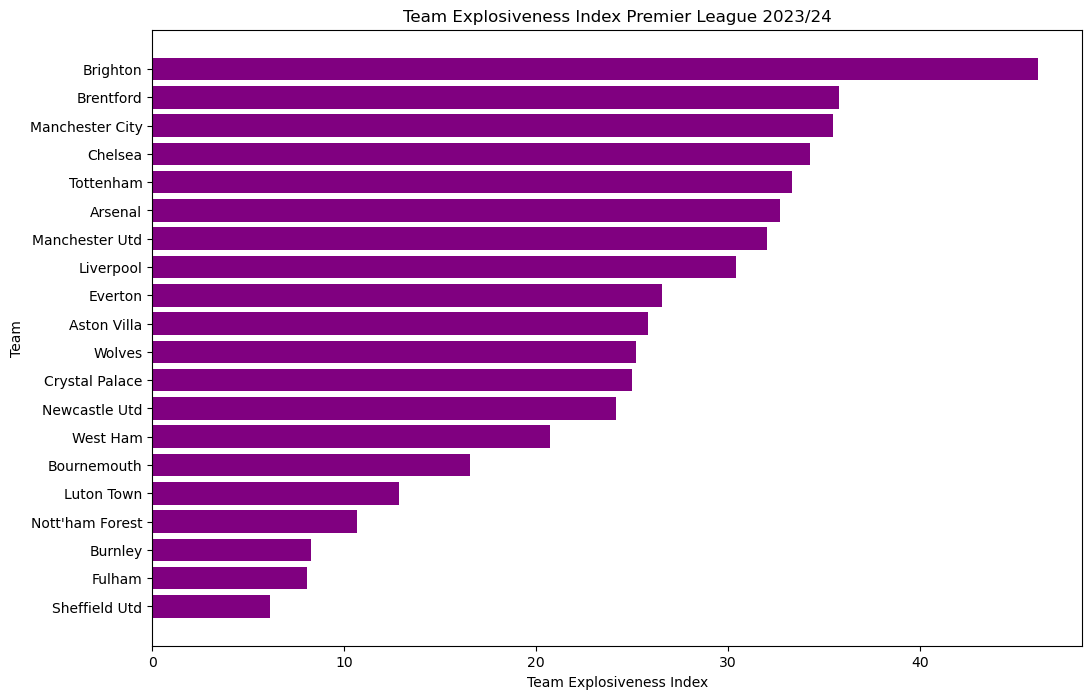

Team Explosiveness Premier League 2023/24:
              Squad  Team Explosiveness Index
4          Brighton                  46.12500
3         Brentford                  35.76875
12  Manchester City                  35.47500
6           Chelsea                  34.23750
17        Tottenham                  33.30625
0           Arsenal                  32.68125
13   Manchester Utd                  32.00000
10        Liverpool                  30.40000
8           Everton                  26.55000
1       Aston Villa                  25.83750
19           Wolves                  25.18750
7    Crystal Palace                  25.01250
14    Newcastle Utd                  24.15000
18         West Ham                  20.70000
2       Bournemouth                  16.56250
11       Luton Town                  12.83700
15  Nott'ham Forest                  10.68750
5           Burnley                   8.26400
9            Fulham                   8.04375
16    Sheffield Utd                  

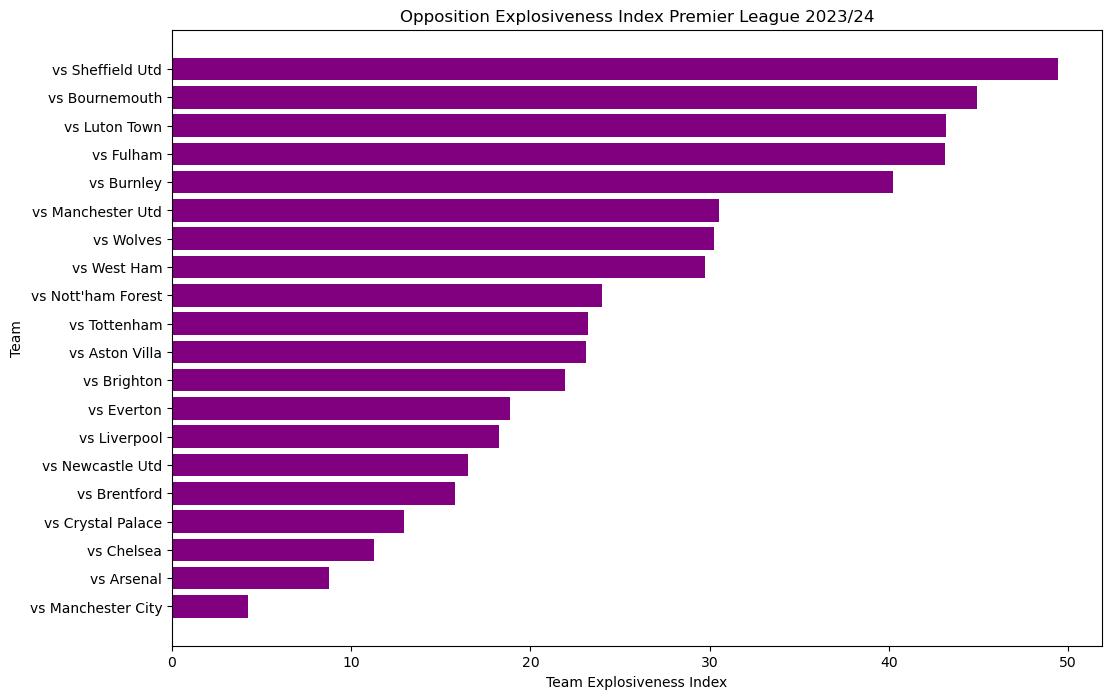

Opposition Explosiveness Premier League 2023/24:
                 Squad  Team Explosiveness Index
16    vs Sheffield Utd                  49.40625
2       vs Bournemouth                  44.93125
11       vs Luton Town                  43.20000
9            vs Fulham                  43.14375
5           vs Burnley                  40.20000
13   vs Manchester Utd                  30.52500
19           vs Wolves                  30.22500
18         vs West Ham                  29.73125
15  vs Nott'ham Forest                  24.00000
17        vs Tottenham                  23.23125
1       vs Aston Villa                  23.07500
4          vs Brighton                  21.93750
8           vs Everton                  18.84375
10        vs Liverpool                  18.21875
14    vs Newcastle Utd                  16.53750
3         vs Brentford                  15.81250
7    vs Crystal Palace                  12.93750
6           vs Chelsea                  11.28750
0           vs Arsen

C:\Users\natha\AppData\Local\Temp\ipykernel_25172\3160869624.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  explosiveness_df['Explosiveness'] = explosiveness_df['npxG/90'] * explosiveness_df['Sh/90']
C:\Users\natha\AppData\Local\Temp\ipykernel_25172\3160869624.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efficiency_df['Efficiency'] = efficiency_df['xG_per_shot'] * efficiency_df['xG']


Player Explosiveness Premier League 2023/24:
                 Player   npxG/90  Sh/90  Explosiveness
274        Darwin Núñez  1.333333   7.50      10.000000
395       Callum Wilson  1.272727   6.30       8.018182
126       Evan Ferguson  1.043478   5.65       5.895652
242         Neal Maupay  1.166667   4.05       4.725000
154      Erling Haaland  0.794872   4.64       3.688205
93       Arnaut Danjuma  0.642857   5.02       3.227143
56         David Brooks  0.800000   3.91       3.128000
116     Odsonne Édouard  0.605263   5.04       3.050526
118      Anthony Elanga  0.600000   5.06       3.036000
172     Nicolas Jackson  0.769231   3.84       2.953846
35        Harvey Barnes  0.700000   3.83       2.681000
397         Yoane Wissa  0.648649   4.10       2.659459
239     Pape Matar Sarr  0.500000   4.17       2.085000
125        Eberechi Eze  0.425000   4.75       2.018750
53         Jarrod Bowen  0.575000   3.25       1.868750
271       Eddie Nketiah  0.466667   3.65       1.703333
29 

In [19]:
analyze_explosiveness("https://fbref.com/en/comps/9/shooting/Premier-League-Stats", "Premier League", "2023/24")

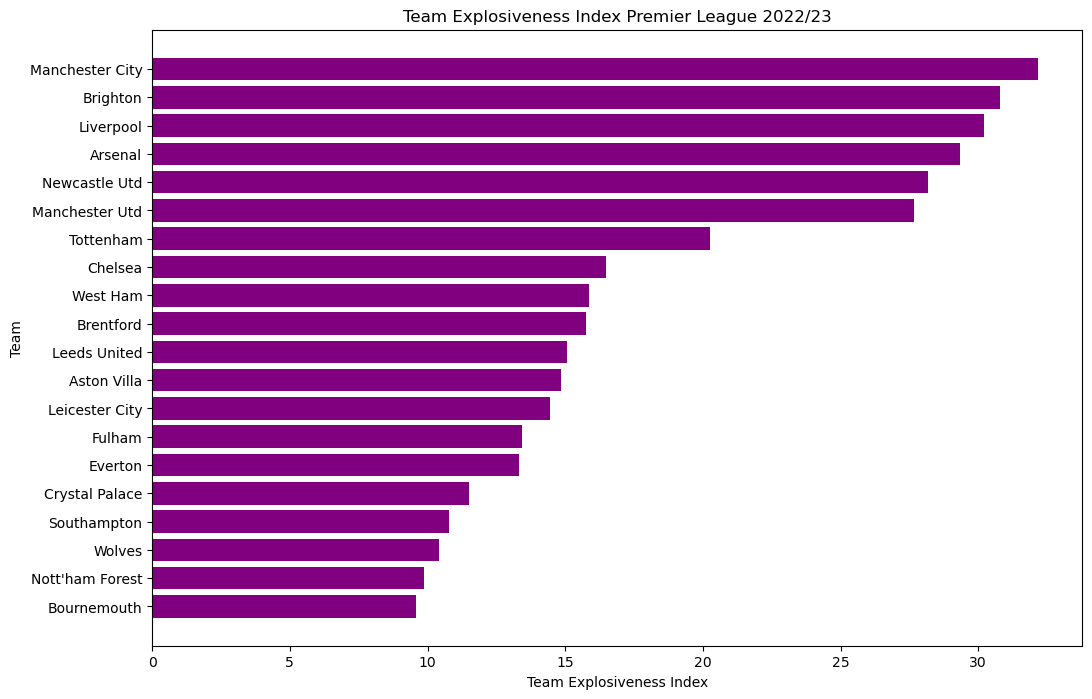

Team Explosiveness Premier League 2022/23:
              Squad  Team Explosiveness Index
12  Manchester City                 32.163447
4          Brighton                 30.805289
11        Liverpool                 30.224526
0           Arsenal                 29.327632
14    Newcastle Utd                 28.174737
13   Manchester Utd                 27.667921
17        Tottenham                 20.240447
5           Chelsea                 16.491316
18         West Ham                 15.873474
3         Brentford                 15.739579
9      Leeds United                 15.068211
1       Aston Villa                 14.848632
10   Leicester City                 14.434316
8            Fulham                 13.434474
7           Everton                 13.334000
6    Crystal Palace                 11.510763
16      Southampton                 10.784184
19           Wolves                 10.420211
15  Nott'ham Forest                  9.856026
2       Bournemouth                  

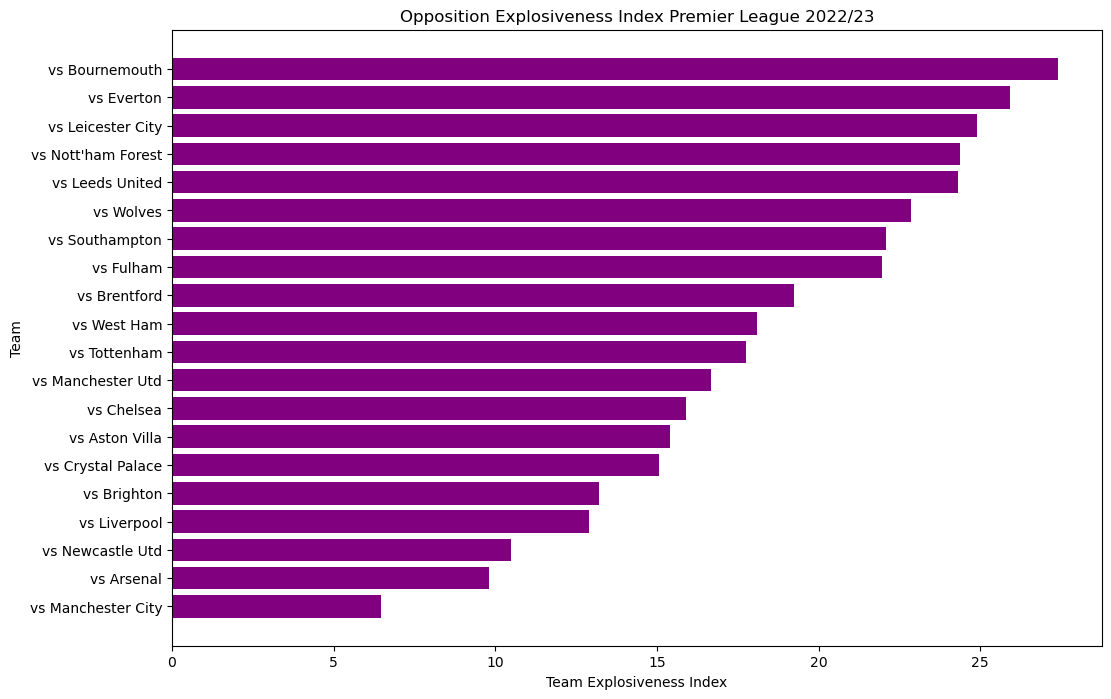

Opposition Explosiveness Premier League 2022/23:
                 Squad  Team Explosiveness Index
2       vs Bournemouth                 27.392921
7           vs Everton                 25.934211
10   vs Leicester City                 24.892842
15  vs Nott'ham Forest                 24.362211
9      vs Leeds United                 24.298105
19           vs Wolves                 22.856579
16      vs Southampton                 22.088421
8            vs Fulham                 21.960632
3         vs Brentford                 19.250895
18         vs West Ham                 18.089737
17        vs Tottenham                 17.761211
13   vs Manchester Utd                 16.685053
5           vs Chelsea                 15.888158
1       vs Aston Villa                 15.418421
6    vs Crystal Palace                 15.050237
4          vs Brighton                 13.210526
11        vs Liverpool                 12.899132
14    vs Newcastle Utd                 10.473158
0           vs Arsen

C:\Users\natha\AppData\Local\Temp\ipykernel_25172\3160869624.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  explosiveness_df['Explosiveness'] = explosiveness_df['npxG/90'] * explosiveness_df['Sh/90']
C:\Users\natha\AppData\Local\Temp\ipykernel_25172\3160869624.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  efficiency_df['Efficiency'] = efficiency_df['xG_per_shot'] * efficiency_df['xG']


PermissionError: [Errno 13] Permission denied: 'C:\\Users\\natha\\Documents\\Football\\Explosiveness Seasons\\Premier_League_2022_23\\Player_Explosiveness.csv'

In [20]:
analyze_explosiveness("https://fbref.com/en/comps/9/2022-2023/shooting/2022-2023-Premier-League-Stats", "Premier League", "2022/23")